# Rossmann Store Sales
### Forecast sales using store, promotion, and competitor data


Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column.

Data fields
* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [2]:
# This is the data which contains store details
store_details = pd.read_csv("../input/store.csv")
store_details

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [3]:
# Our Train data
train_data = pd.read_csv("../input/train.csv")
train_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
# merged our train data and store details data based on store number to get complete info for each store
combined_data = pd.merge(train_data, store_details, on='Store')
combined_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [5]:
combined_data.shape

(1017209, 18)

## Exploring Dataset

In [6]:
# missing values in the dataset
print("Total size of dataset: ", len(combined_data))
print(combined_data.isnull().sum())

Total size of dataset:  1017209
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


In [9]:
compute_fill_rate(combined_data)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.997403,0.682122,0.682122,1.0,0.500564,0.500564,0.500564


In [10]:
combined_data.columns.shape

(18,)

In [11]:
pd.DataFrame(combined_data.isnull().sum(), combined_data.columns)

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


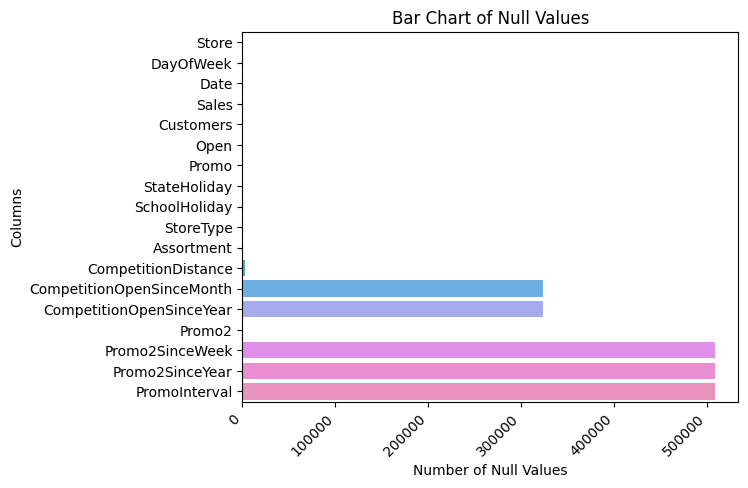

In [12]:
null_counts = combined_data.isnull().sum()

# Convert null_counts to a DataFrame
null_counts_df = pd.DataFrame({'Null Count': null_counts.values, 'Column': null_counts.index})

# Plotting the null counts as a bar chart
sns.barplot(y='Column', x='Null Count', data=null_counts_df)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.ylabel('Columns')
plt.xlabel('Number of Null Values')
plt.title('Bar Chart of Null Values')
plt.show()

In [8]:
def compute_fill_rate( df ) :
    """
    Computing the rate of non-NaNs for each column
    Params :
        df : Pandas dataframe, input data
    Return :
        Pandas dataframe
    """
    fr = pd.DataFrame(df.notnull().sum().values.reshape(1,-1)/df.shape[0], 
                         columns=df.columns)
    return fr

###########################################
def plot_fill_rate( df ) : 
    """
    Plot the fill rate
    df : Pandas dataframe, input data
    """
    fill_rate = compute_fill_rate( df )
    fig, ax = plt.subplots( figsize=(18,18) )
    sns.barplot(data=fill_rate, orient="h")
    ax.set_title( "Fill rate for columns", fontsize=28 )
    ax.set(xlim=(0, 1.))
    
    
###########################################
def drop_empty_axis( df, minFillRate, axis=1 ) :
    """
    Drops axes that do not meet the minimum non-Nan rate
    Params :
        df : Pandas dataframe
        minFillRate : float, minimum filled fraction [0,1]
        axis : int, 1 for column, 0 for row
    Returns :
        Pandas dataframe 
    """
    i = 0 if axis==1 else 1 
    return df.dropna( axis=axis, thresh=int(df.shape[i]*minFillRate) )



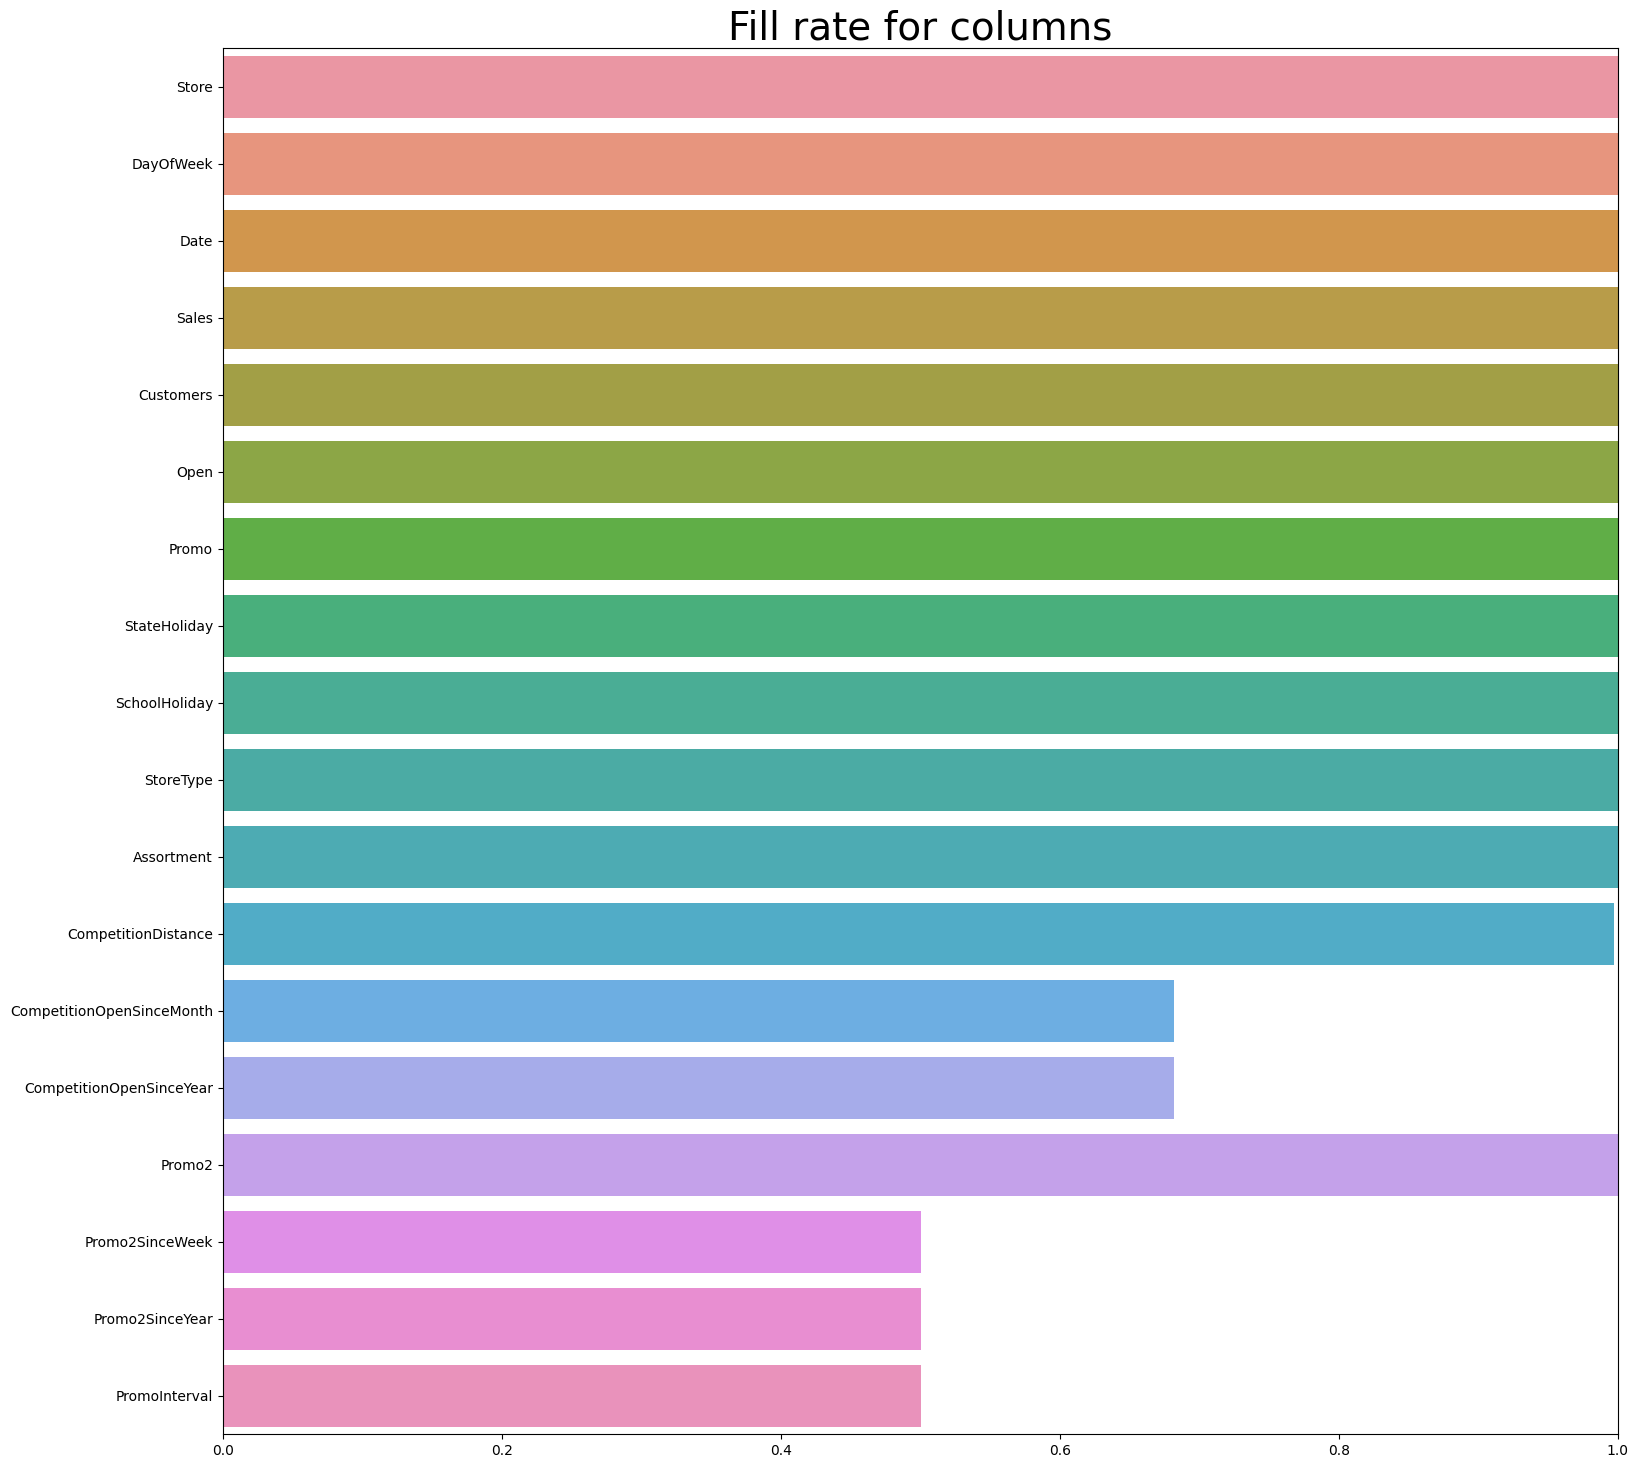

In [13]:
plot_fill_rate(combined_data)

In [14]:
cols = combined_data.columns

In [15]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [16]:
def print_uniques(cols, df):
    for col in cols:
        list_unique = df[col].unique()
        list_unique.sort()
        print(col, ":\n", list_unique)
        print("Number of unique categories:", len(list_unique))
        print("--------------------")

In [17]:
# unique values in dataset
columns = list(combined_data.columns)
columns.remove('Date')
columns.remove('CompetitionDistance')
for col in columns:
    print(col,"-------->",combined_data[col].unique(), "\nCount:", combined_data[col].nunique())

Store --------> [   1    2    3 ... 1113 1114 1115] 
Count: 1115
DayOfWeek --------> [5 4 3 2 1 7 6] 
Count: 7
Sales --------> [ 5263  5020  4782 ... 20362 18841 21237] 
Count: 21734
Customers --------> [ 555  546  523 ... 3727 4022 4106] 
Count: 4086
Open --------> [1 0] 
Count: 2
Promo --------> [1 0] 
Count: 2
StateHoliday --------> ['0' 'a' 'b' 'c' 0] 
Count: 5
SchoolHoliday --------> [1 0] 
Count: 2
StoreType --------> ['c' 'a' 'd' 'b'] 
Count: 4
Assortment --------> ['a' 'c' 'b'] 
Count: 3
CompetitionOpenSinceMonth --------> [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.] 
Count: 12
CompetitionOpenSinceYear --------> [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.] 
Count: 23
Promo2 --------> [0 1] 
Count: 2
Promo2SinceWeek --------> [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.] 
Count: 24
Promo2SinceYear --------> [  nan

In [18]:
combined_data['Date'][0] 

'2015-07-31'

In [22]:
combined_data['Date'].apply(lambda x: int(str(x)[8:])) #Date

0          31
1          30
2          29
3          28
4          27
           ..
1017204     5
1017205     4
1017206     3
1017207     2
1017208     1
Name: Date, Length: 1017209, dtype: int64

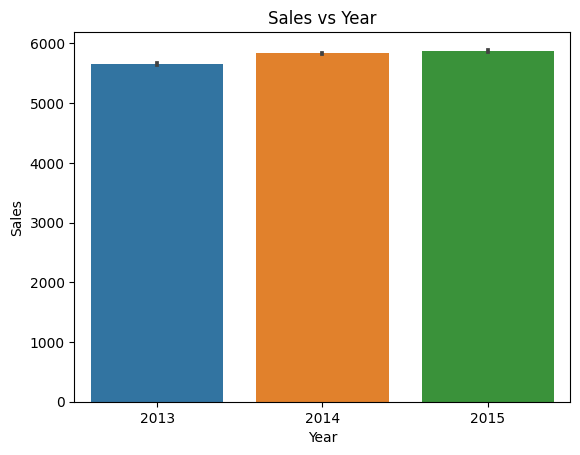

In [26]:
# extracting year and month from Date 
combined_data['Year']  = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))
#combined_data['Date'].apply(lambda x: int(str(x)[8:-1]))

# Sales with respect to year 
sns.barplot(x='Year', y='Sales', data=combined_data)

plt.title('Sales vs Year')
plt.show()


##### Sales have been increasing year to year

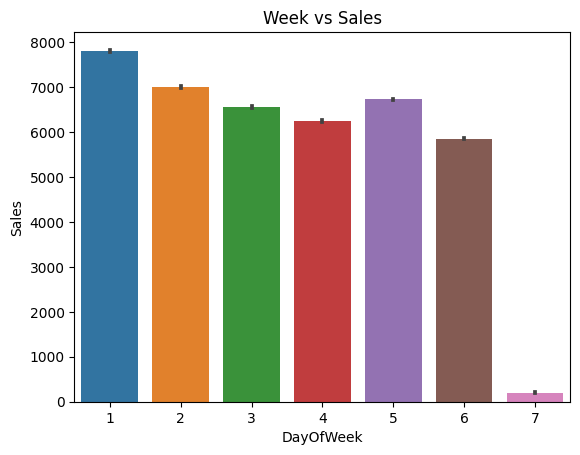

In [24]:
# Sales with respect to week
sns.barplot(x='DayOfWeek', y='Sales', data=combined_data).set(title='Week vs Sales')
plt.show()

##### Sales on 1 (Monday) and 5 (Friday) are the highest

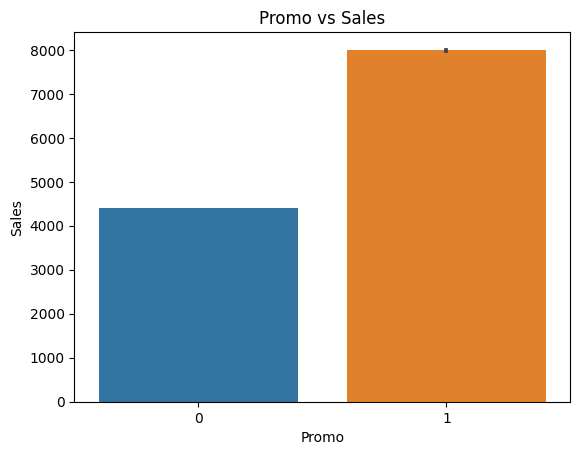

In [25]:
# Sales with respect to Promo
sns.barplot(x='Promo', y='Sales', data=combined_data).set(title='Promo vs Sales')
plt.show()

##### Customers are definately attracted by Promo codes thus sales are higher when there is a Promo code in a Store

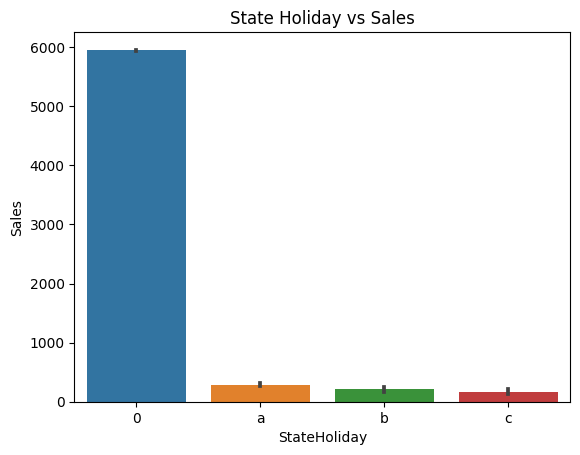

In [27]:
# StateHoliday column has values 0 & "0", So, we need to change values with 0 to "0"
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == 0] = "0"

# Sales with respect to State Holiday
sns.barplot(x='StateHoliday', y='Sales', data=combined_data).set(title='State Holiday vs Sales')
plt.show()

##### Most stores are closed on State Holidays that's why we can see that there are very less sales in a,b,c where:
* a = Public Holiday
* b = Easter Holiday
* c = Chirstmas 
* 0 = No Holiday, Working day

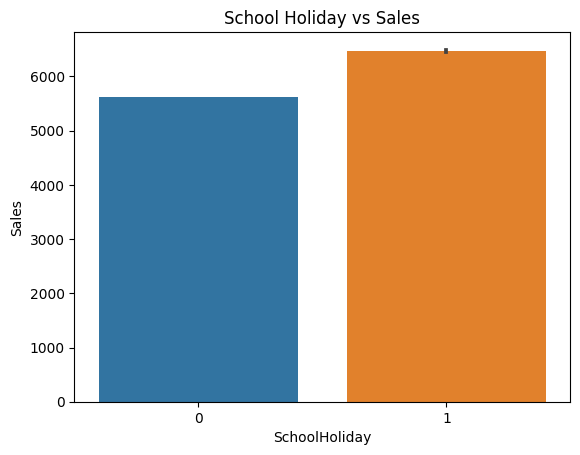

In [28]:
# Sales with respect to School Holiday
sns.barplot(x='SchoolHoliday', y='Sales', data=combined_data).set(title='School Holiday vs Sales')
plt.show()

##### On School Holidays there are more sales!

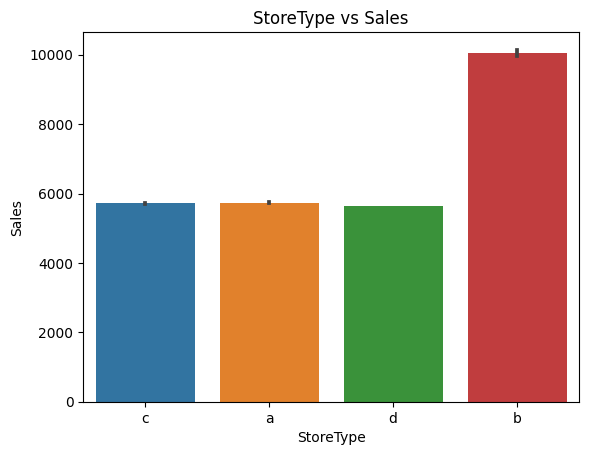

In [29]:
# Sales with respect to StoreType
sns.barplot(x='StoreType', y='Sales', data=combined_data).set(title='StoreType vs Sales')
plt.show()

##### a,b,c,d are store models where b type stores have the highest sales 

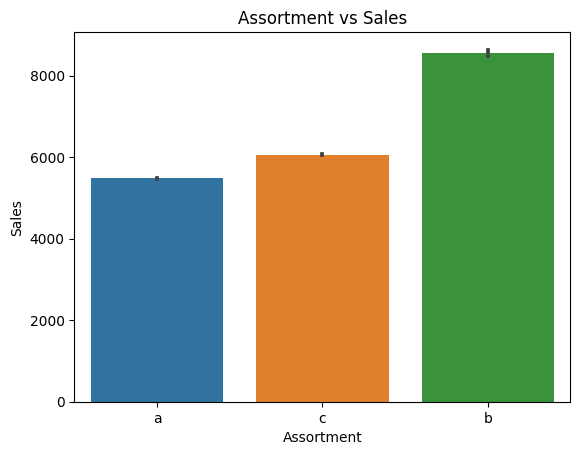

In [30]:
# Sales with respect to Assortment
sns.barplot(x='Assortment', y='Sales', data=combined_data).set(title='Assortment vs Sales')
plt.show()

##### Assortment level b have the highest sales
##### Assortment levels:
* a = basic
* b = extra
* c = entended

## Filling Missing Values and Removing Outliers

Few columns have high number of missing values, so we need to fill them with appropriate method for better result

### Filling Missing Values
##### Approach
1: The null values in Column Promo2SinceWeek, Promo2SinceYear, PromoInterval is due to Promo2 is 0 for those stores. So we would fill all the null values in these columns with 0.

2: Since Competition Distance for 3 stores isn't given so we could fill it with mean of the distance given for all other stores

3: CompetitionOpenSinceMonth, CompetitionOpenSinceYear can be filled using the most occuring month and year respectively. 

In [31]:
store_details.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [32]:
pd.DataFrame({'Percentage of Null Values': (store_details.isnull().mean()) * 100})\
            .sort_values(by='Percentage of Null Values', ascending=False)

,Percentage of Null Values
Promo2SinceWeek,48.789238
Promo2SinceYear,48.789238
PromoInterval,48.789238
CompetitionOpenSinceMonth,31.748879
CompetitionOpenSinceYear,31.748879
CompetitionDistance,0.269058
Store,0.000000
StoreType,0.000000
Assortment,0.000000
Promo2,0.000000


In [33]:
train_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [34]:
# Filling Promo2SinceWeek, Promo2SinceYear, PromoInterval with 0
store_details.update(store_details[['Promo2SinceWeek','Promo2SinceYear','PromoInterval']].fillna(0))

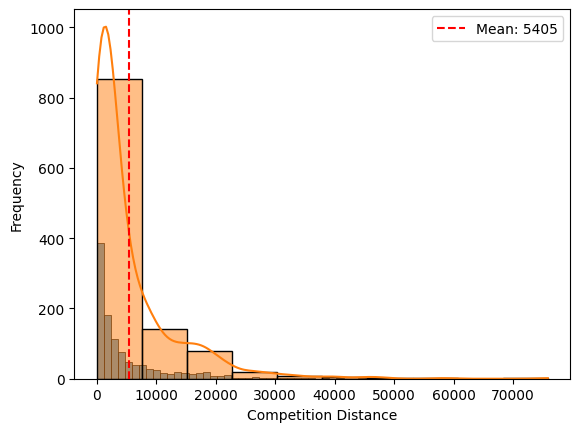

In [35]:
mean_CD = store_details['CompetitionDistance'].mean()
sns.histplot(store_details['CompetitionDistance'])
sns.histplot(data=store_details['CompetitionDistance'], bins=10, kde=True)
plt.axvline(x=mean_CD, color='red', linestyle='--', label=f'Mean: {mean_CD:.0f}')

plt.xlabel('Competition Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [36]:
# Filling CompetitionDistance with mean distance
mean_competition_distance = store_details['CompetitionDistance'].mean()
store_details['CompetitionDistance'].fillna(mean_competition_distance, inplace=True)

In [37]:
store_details['CompetitionOpenSinceMonth'].mode()[0]

9.0

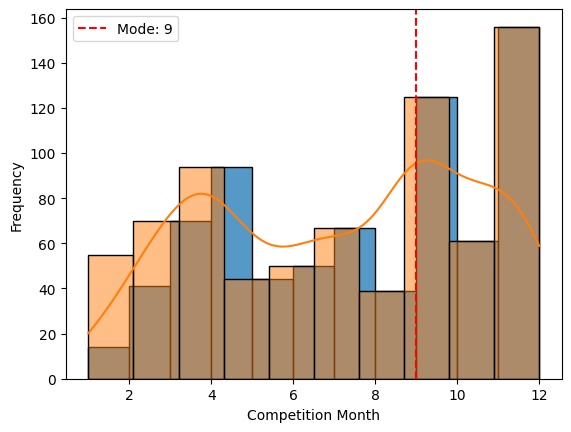

In [38]:
mode_OM = store_details['CompetitionOpenSinceMonth'].mode()[0]
sns.histplot(store_details['CompetitionOpenSinceMonth'])
sns.histplot(data=store_details['CompetitionOpenSinceMonth'], bins=10, kde=True)
plt.axvline(x=mode_OM, color='red', linestyle='--', label=f'Mode: {mode_OM:.0f}')

plt.xlabel('Competition Month')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [39]:
# Filling CompetitionOpenSinceMonth, CompetitionOpenSinceYear with most occuring month and year respectively
mode_competition_open_month = store_details['CompetitionOpenSinceMonth'].mode()[0]

mode_competition_open_year = store_details['CompetitionOpenSinceYear'].mode()[0]

store_details['CompetitionOpenSinceMonth'].fillna(mode_competition_open_month,inplace=True)
store_details['CompetitionOpenSinceYear'].fillna(mode_competition_open_year,inplace=True)

In [40]:
store_details.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

* All missing values have been filled

In [41]:
# merging the data again
combined_data = pd.merge(train_data, store_details, on='Store')
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [42]:
combined_data.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

<Axes: title={'center': 'Sales vs CompetitionDistance'}, xlabel='CompetitionDistance', ylabel='Sales'>

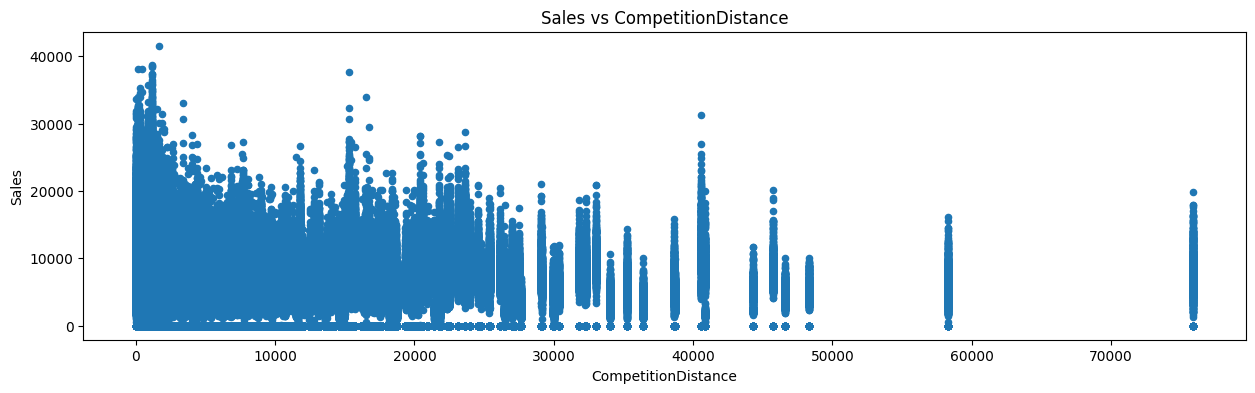

In [43]:
combined_data.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4),title="Sales vs CompetitionDistance")

* CompetitionDistance is the distance in meters to the nearest competitor store, the more nearer the two stores are the more sales can be seen

### Finding Outliers

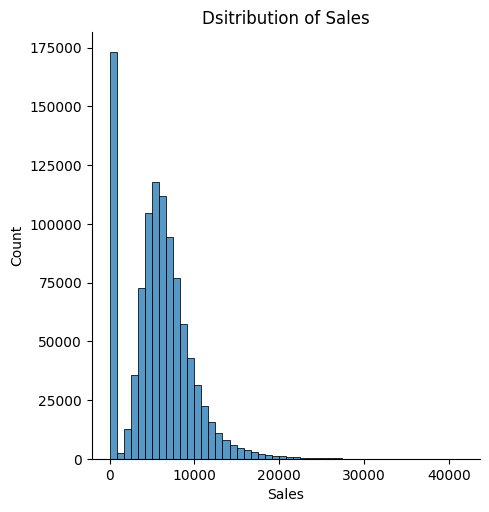

In [191]:
# checking distribution of sales 
sns.displot(combined_data, x="Sales",bins=50).set(title='Dsitribution of Sales')

* As we can see in the distribution plot Sales greater than 30k are very less so they might be the outliers

### Z-Score: If the Z-Score of a datapoint is greater than 3 that can be considered as an Outlier

Mean of Sales:  5773.818972305593
Standard Deviation of Sales:  3849.924282837463
Total outlier in dataset are:  9731
Maximum Sales Outlier:  41551
Minimum Sales Outlier:  17325


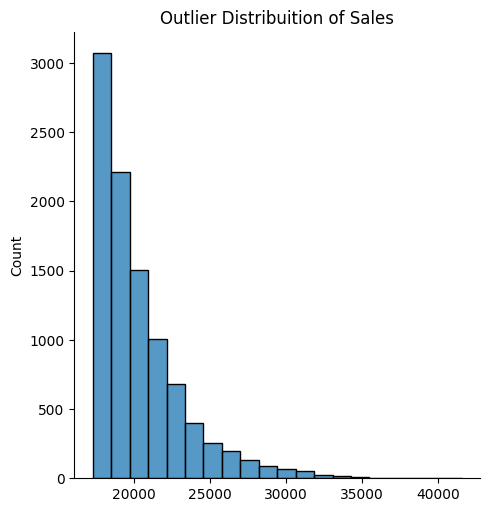

In [44]:
mean_of_sales = np.mean(combined_data['Sales']) 
std_of_sales = np.std(combined_data['Sales'])
print("Mean of Sales: ",mean_of_sales)
print("Standard Deviation of Sales: ",std_of_sales)

threshold = 3
outlier = [] 
for i in combined_data['Sales']: 
    z = (i-mean_of_sales)/std_of_sales
    if z > threshold: 
        outlier.append(i) 
print('Total outlier in dataset are: ', len(outlier))
print("Maximum Sales Outlier: ", max(outlier))
print("Minimum Sales Outlier: ", min(outlier))

sns.displot(x=outlier,bins=20).set(title='Outlier Distribuition of Sales')

In [45]:
# Looking for outliers
sales_zero = combined_data.loc[combined_data['Sales'] == 0] 
sales_greater_than_30 = combined_data.loc[combined_data['Sales'] > 30000]

print("Length of actual dataset:", len(combined_data))
print("Length of data where sales is 0:", len(sales_zero),
      " which is", len(sales_zero)/len(combined_data)*100, "% of the whole data", )

print("Length of data which is greater than 30:", len(sales_greater_than_30),
      "which is ", len(sales_greater_than_30)/len(combined_data)*100, "% of the whole data")

Length of actual dataset: 1017209
Length of data where sales is 0: 172871  which is 16.994639253093514 % of the whole data
Length of data which is greater than 30: 153 which is  0.015041156733768577 % of the whole data


* Droping sales which are greater than 30k as they are very less in the dataset and are probably outliers

In [46]:
combined_data.drop(combined_data.loc[combined_data['Sales'] > 30000].index,inplace=True)
combined_data.shape

(1017056, 18)

## Further EDA - exploring exceptional cases
Looking for a scenerio where the Stores are open and yet there is no sales on that day

In [47]:
# no sales when Stores were Open
no_holiday_zero_sales = combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) & 
                                          (combined_data['StateHoliday'] == 0) & (combined_data['SchoolHoliday'] == 0)]

print("Size of the data where sales were zero even when stores were open: ",len(no_holiday_zero_sales))
no_holiday_zero_sales

Size of the data where sales were zero even when stores were open:  12


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
22589,25,4,2014-02-13,0,0,1,0,0,0,c,a,430.0,4.0,2003.0,0,0.0,0.0,0
22590,25,3,2014-02-12,0,0,1,0,0,0,c,a,430.0,4.0,2003.0,0,0.0,0.0,0
25212,28,4,2014-09-04,0,0,1,1,0,0,a,a,1200.0,10.0,2014.0,1,6.0,2015.0,"Mar,Jun,Sept,Dec"
205303,227,4,2014-09-11,0,0,1,0,0,0,a,a,2370.0,9.0,2013.0,0,0.0,0.0,0
297110,327,3,2014-03-12,0,0,1,0,0,0,c,c,1390.0,12.0,2004.0,0,0.0,0.0,0
324624,357,1,2014-09-22,0,0,1,0,0,0,a,a,2060.0,10.0,2008.0,0,0.0,0.0,0
567892,623,6,2014-01-25,0,0,1,0,0,0,a,a,4080.0,3.0,2011.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
567893,623,5,2014-01-24,0,0,1,1,0,0,a,a,4080.0,3.0,2011.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
760375,835,4,2014-09-11,0,0,1,0,0,0,a,a,2890.0,12.0,2007.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
760376,835,3,2014-09-10,0,0,1,0,0,0,a,a,2890.0,12.0,2007.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"


* Removing these data points too as they are an exceptional case

In [48]:
combined_data.drop(combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) & 
                                     (combined_data['StateHoliday'] == 0) & 
                                     (combined_data['SchoolHoliday'] == 0)].index,inplace=True)
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [49]:
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## Converting Categorical Variable to Numeric

In [50]:
# extracting year and month from Date 
combined_data['Year']  = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))
combined_data.drop(['Date'],axis=1,inplace=True)

In [51]:
combined_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [52]:
# encoding all categorical varibale to numeric values
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

combined_data['StoreType']= label_encoder.fit_transform(combined_data['StoreType'])
combined_data['Assortment']= label_encoder.fit_transform(combined_data['Assortment']) 

# for promo interval
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Jan,Apr,Jul,Oct"] = 1
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Feb,May,Aug,Nov"] = 2
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Mar,Jun,Sept,Dec"] = 3
'''
new_promo_interval = []
for i in range(len(combined_data)):
    if combined_data['PromoInterval'][i] == 'Jan,Apr,Jul,Oct':
        new_promo_interval.append(1)
    elif combined_data['PromoInterval'][i] == 'Feb,May,Aug,Nov':
        new_promo_interval.append(2)
    elif combined_data['PromoInterval'][i] == 'Mar,Jun,Sept,Dec':
        new_promo_interval.append(3)
    else:
        new_promo_interval.append(0)
        
combined_data['PromoInterval'] = new_promo_interval        
'''

# for State Holiday
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "a"] = 1
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "b"] = 2
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "c"] = 3

'''
state_holiday_list = []
for i in range(len(combined_data)):
    if combined_data['StateHoliday'][i] == 'a':
        state_holiday_list.append(1)
    elif combined_data['StateHoliday'][i] == 'b':
        state_holiday_list.append(2)
    elif combined_data['StateHoliday'][i] == 'c':
        state_holiday_list.append(3)
    else:
        state_holiday_list.append(0)


combined_data['StateHoliday'] = state_holiday_list
'''
combined_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [53]:
combined_data.StoreType.unique(), combined_data.StoreType.nunique()

(array([2, 0, 3, 1]), 4)

In [54]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017044 entries, 0 to 1017208
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017044 non-null  int64  
 1   DayOfWeek                  1017044 non-null  int64  
 2   Sales                      1017044 non-null  int64  
 3   Customers                  1017044 non-null  int64  
 4   Open                       1017044 non-null  int64  
 5   Promo                      1017044 non-null  int64  
 6   StateHoliday               1017044 non-null  object 
 7   SchoolHoliday              1017044 non-null  int64  
 8   StoreType                  1017044 non-null  int64  
 9   Assortment                 1017044 non-null  int64  
 10  CompetitionDistance        1017044 non-null  float64
 11  CompetitionOpenSinceMonth  1017044 non-null  float64
 12  CompetitionOpenSinceYear   1017044 non-null  float64
 13  Promo2      

In [55]:
combined_data['StateHoliday'] = pd.to_numeric(combined_data['StateHoliday'])
combined_data['PromoInterval'] = pd.to_numeric(combined_data['PromoInterval'])

<Axes: >

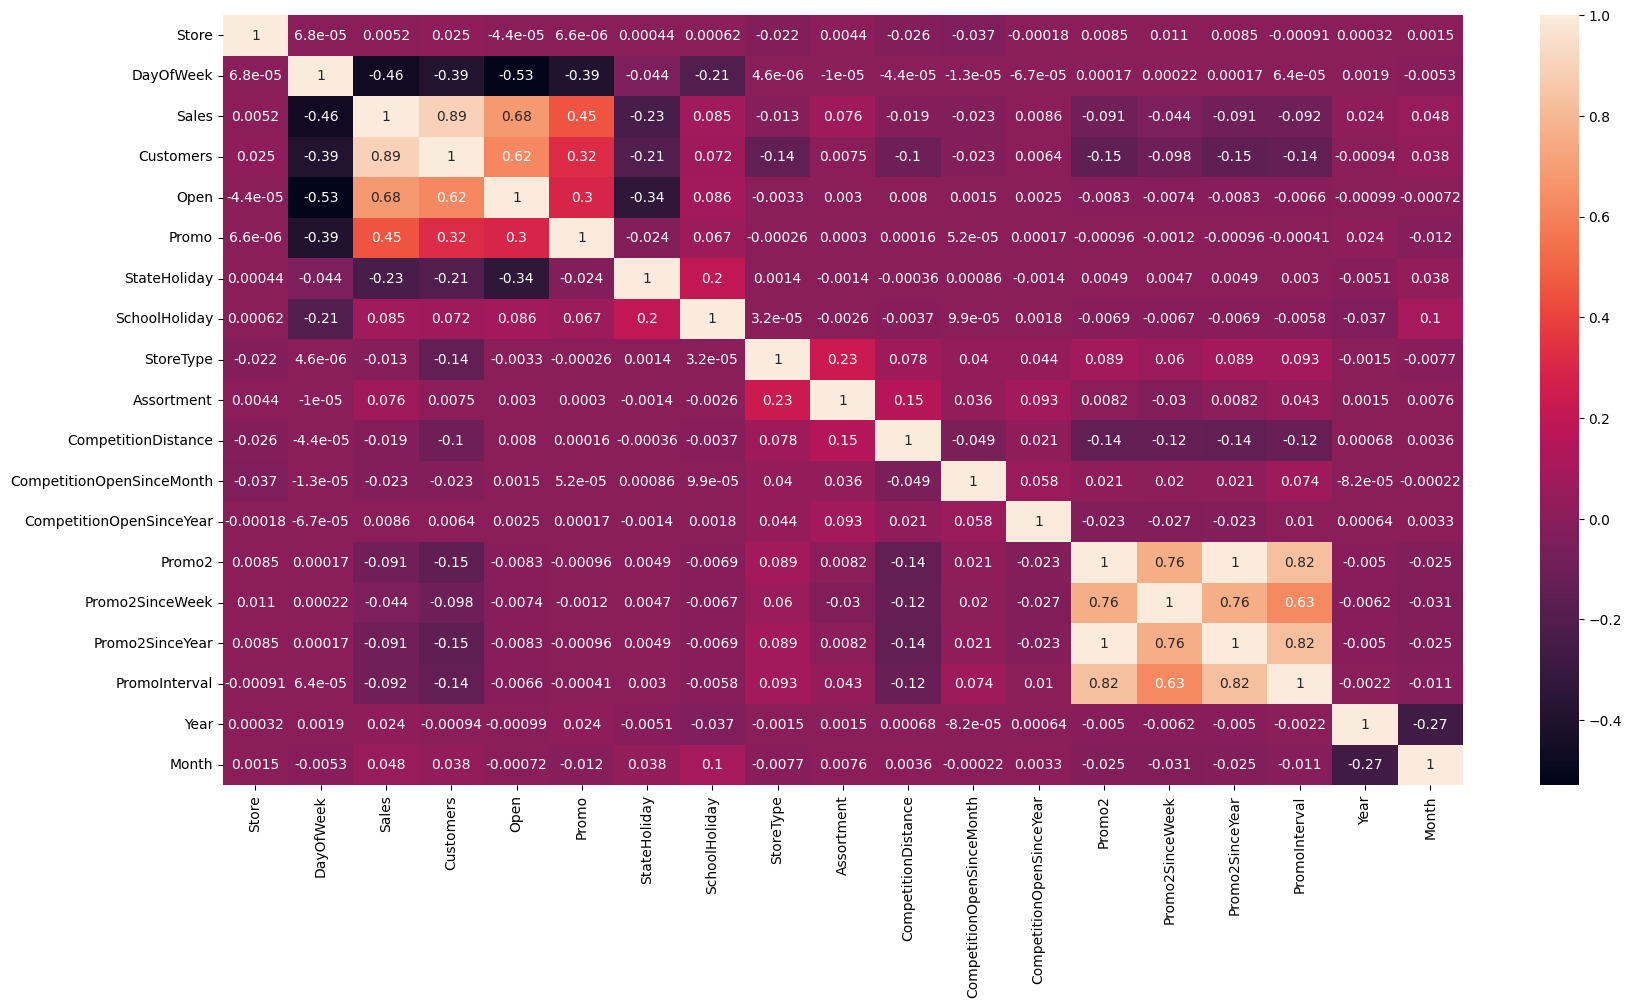

In [57]:
plt.figure(figsize=(20,10))
sns.heatmap(combined_data.corr(),annot=True)

##### Correlation map shows
* Sales is highly correlated with Customers, Open, Promo code
* Promo code is highly correlated to Promo2SinceWeek, Promo2SinceYear, PromoInterval

## Implementing Models

In [58]:

combined_data[combined_data['Open']==0]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
5,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
12,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
19,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
26,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
33,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017182,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017189,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017196,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017203,1115,7,0,0,0,0,0,1,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1


In [59]:
per_open = len(combined_data[combined_data['Open']==1])\
/(len(combined_data[combined_data['Open']==0])\
+len(combined_data[combined_data['Open']==1]))*100
print(f'Store is open {per_open: .2f} percent')

Store is open  83.01 percent


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math  

In [61]:
combined_data_subset = combined_data[combined_data['Open'] == 1]
combined_data_subset_closed = combined_data[combined_data['Open'] == 0]
x_train, x_test, y_train, y_test_open = train_test_split(combined_data_subset.drop(['Sales','Customers', 'Open'],axis=1),
                                                    combined_data_subset['Sales'],test_size=0.20)

In [62]:
epsilon = 1e-10

In [63]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month'],
      dtype='object')

## Linear Regression

In [64]:
from sklearn import linear_model

reg_model = linear_model.LinearRegression() # making regression model
reg_model.fit(x_train, y_train) 

prediction_open = reg_model.predict(x_test)

prediction_closed = np.zeros(combined_data_subset_closed.shape[0]) #closed prediction

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))

r2_score:  0.773516379478933
Mean absolute error: 1001.69
Root mean squared error:  1952.3010477118962


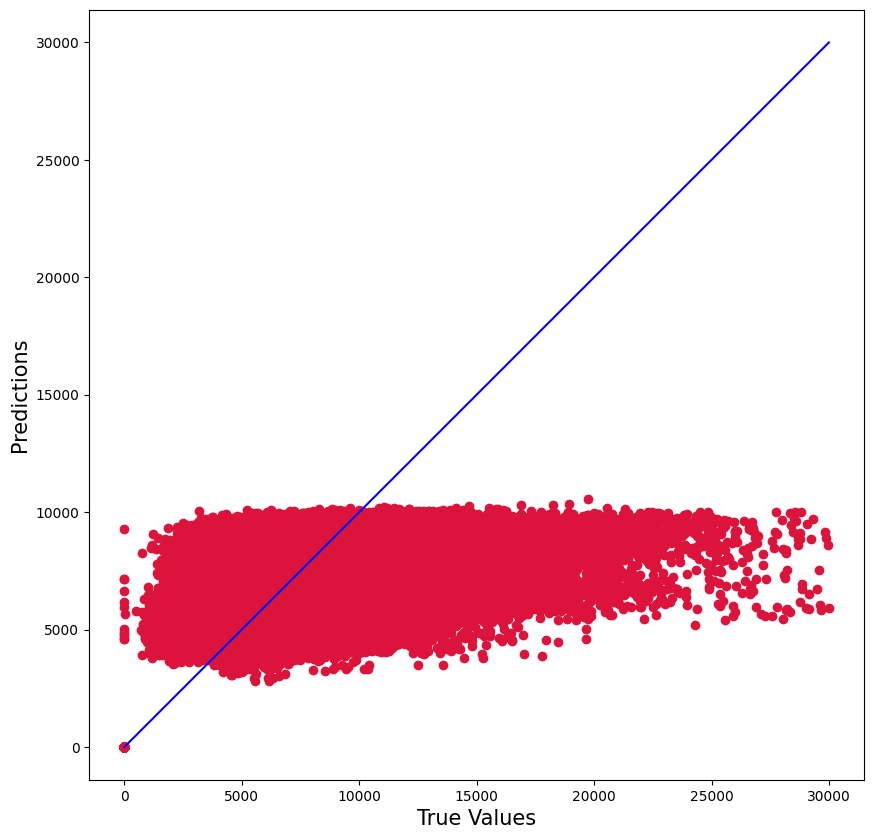

In [65]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## SGD Regressor
Stochastic Gradient Descent (SGD) is a simple yet efficient optimization algorithm used to find the values of parameters/coefficients of functions that minimize a cost function. 

r2_score:  -2.712188387251325e+25
Mean absolute error: 8958808316826914.00
Root mean squared error:  2.136428259426281e+16


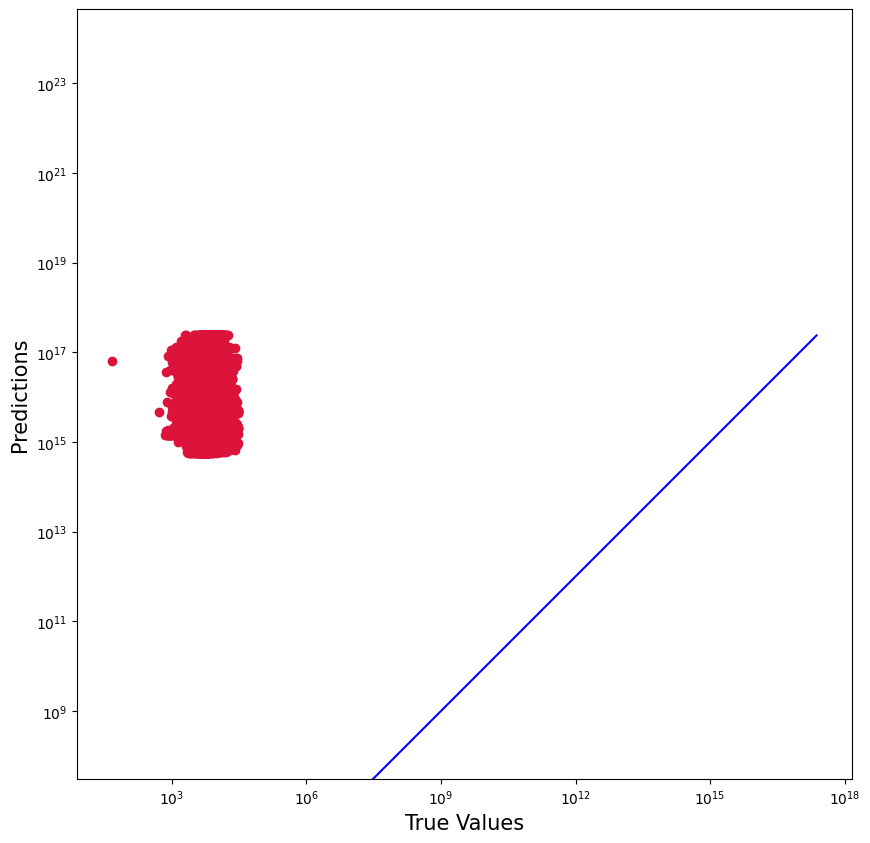

In [66]:
from sklearn.linear_model import SGDRegressor
sgd_regressor_model = SGDRegressor(max_iter=2)  # increasing this value leads to over fitting
sgd_regressor_model.fit(x_train,y_train)

prediction_open = sgd_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))

plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Random Forest Regressor

r2_score:  0.9651665497139506
Mean absolute error: 358.00
Root mean squared error:  765.643561547051


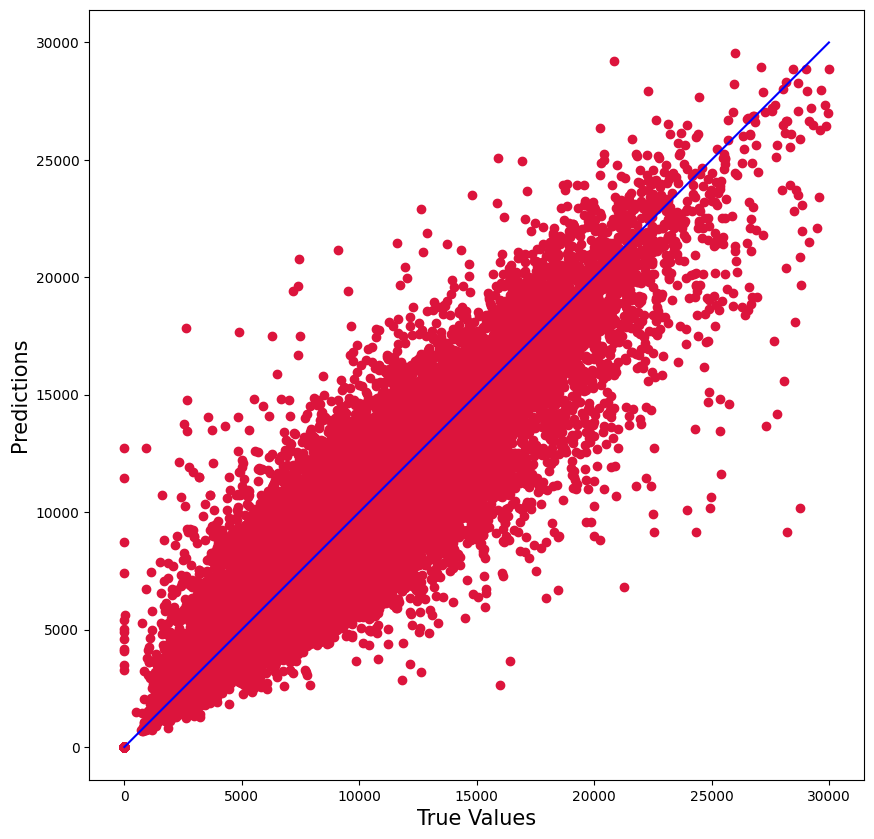

In [67]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(x_train,y_train)

prediction_open = random_forest_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))


plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Decision Tree Regressor

r2_score:  0.9514684092739513
Mean absolute error: 422.91
Root mean squared error:  903.734061647885


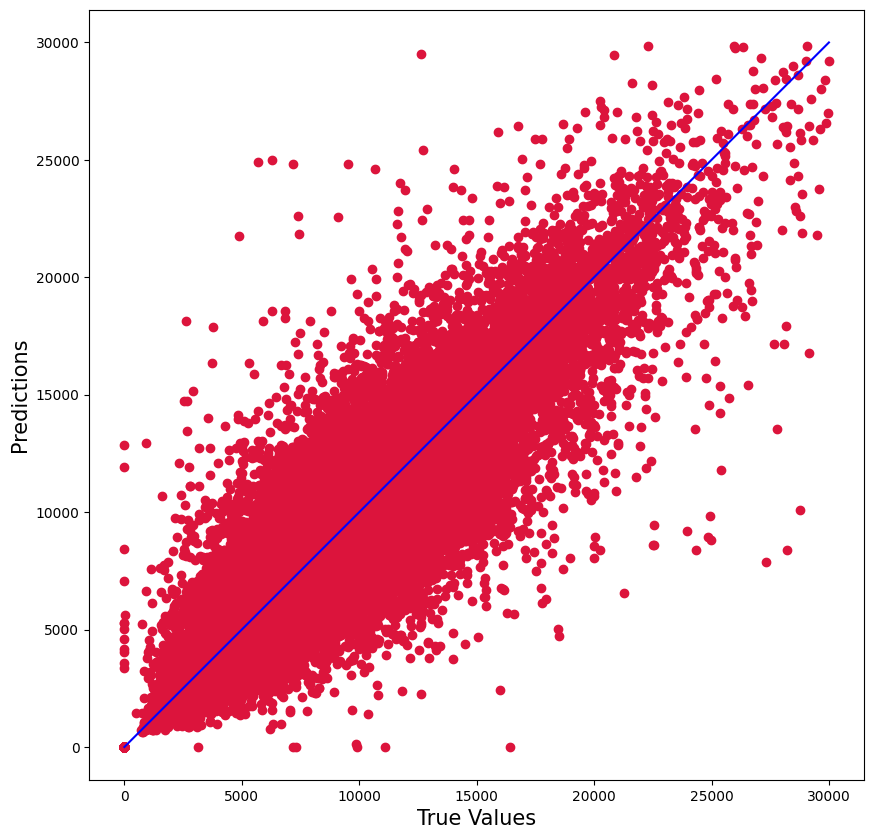

In [68]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_regressor_model = DecisionTreeRegressor()
decision_tree_regressor_model.fit(x_train,y_train)

prediction_open = decision_tree_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))


plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Random Forest Regressor had the lowest error as compared to other stores that means it is better at predicting sales than other models so we have selected that as our model

## Understanding the important features


In [69]:
# getting weights of all the features used in the data
feature_importance = random_forest_regressor_model.feature_importances_
feature_importance

array([0.18094004, 0.08199749, 0.14010051, 0.00126077, 0.0126183 ,
       0.03619869, 0.03258713, 0.20425789, 0.06905982, 0.07710251,
       0.00311089, 0.02975768, 0.03189918, 0.01269356, 0.02378269,
       0.06263284])

In [70]:
# features used
columns = list(x_train.columns)
columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'Year',
 'Month']

In [71]:
feature_importance_value = []
for i in range(len(feature_importance)):
    feature_importance_value.append(round(feature_importance[i],5))
feature_importance_value

[0.18094,
 0.082,
 0.1401,
 0.00126,
 0.01262,
 0.0362,
 0.03259,
 0.20426,
 0.06906,
 0.0771,
 0.00311,
 0.02976,
 0.0319,
 0.01269,
 0.02378,
 0.06263]

In [72]:
# making a dataframe
feature_importance_df = pd.DataFrame({"Features":columns,
                                     "Values":feature_importance_value })
feature_importance_df

,Features,Values
0,Store,0.18094
1,DayOfWeek,0.08200
2,Promo,0.14010
3,StateHoliday,0.00126
4,SchoolHoliday,0.01262
5,StoreType,0.03620
6,Assortment,0.03259
7,CompetitionDistance,0.20426
8,CompetitionOpenSinceMonth,0.06906
9,CompetitionOpenSinceYear,0.07710


In [73]:
feature_importance_df.sort_values(by=["Values"], inplace=True, ascending=False)
feature_importance_df

,Features,Values
7,CompetitionDistance,0.20426
0,Store,0.18094
2,Promo,0.14010
1,DayOfWeek,0.08200
9,CompetitionOpenSinceYear,0.07710
8,CompetitionOpenSinceMonth,0.06906
15,Month,0.06263
5,StoreType,0.03620
6,Assortment,0.03259
12,Promo2SinceYear,0.03190


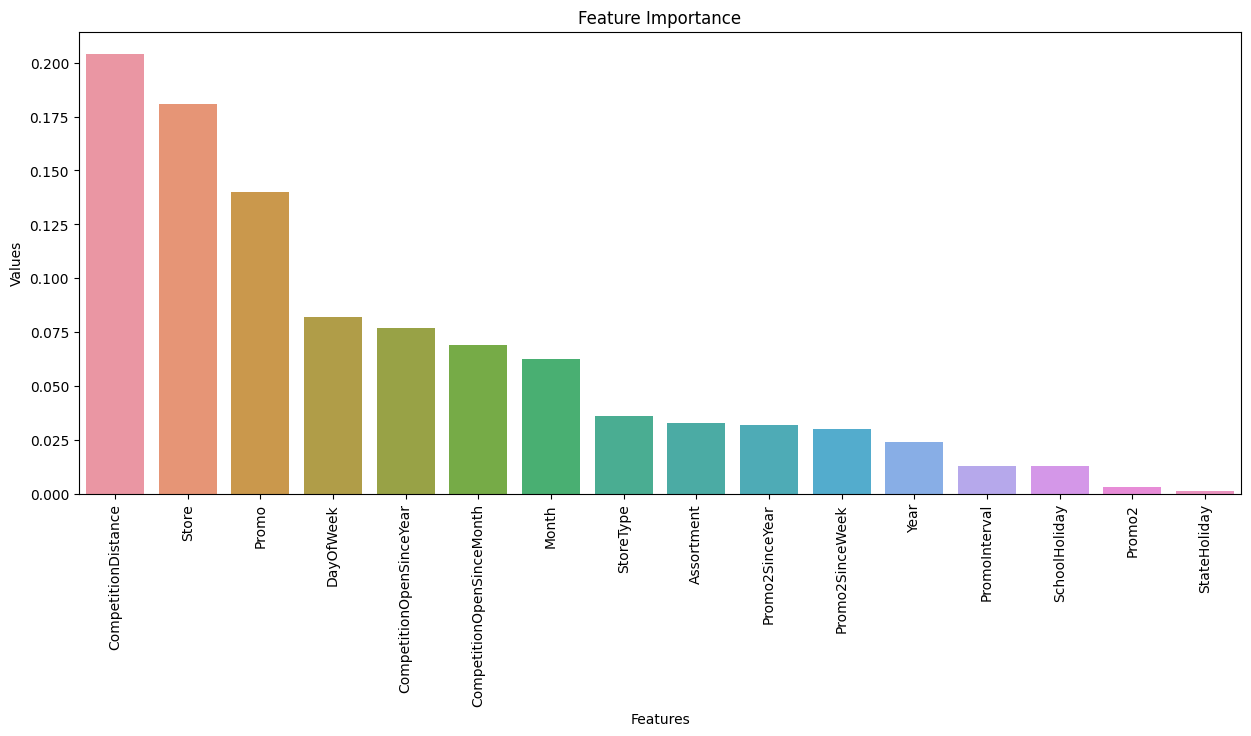

In [74]:
# Feature Importance
plt.figure(figsize=(15,6))

sns.barplot(x=feature_importance_df['Features'], y=feature_importance_df['Values'],
            data = feature_importance_df ).set(title='Feature Importance')

plt.xticks(rotation=90)
plt.show()

## Conclusion
* Random Forest Regressor had the lowest error as compared to other stores that means it is better at predicting sales than other models so we have selected that as our model.
* Feature engineering is very important. e.g. removal of the 'Open'. feature
* Closer competiton distance make stores more competitive and thus using Promo codes can help them to boost sales 
* Store Type affects the sales
* Promo code can help increase in the competition and lead to more sales
* Since most of the stores are closed on Holidays, the feature has no effect on sales